In [1]:
from dotenv import load_dotenv
import os

# Load .env file
load_dotenv()

# Azure Credentials
AZURE_SQL_SERVER = os.getenv('AZURE_SQL_SERVER', '')
AZURE_SQL_DATABASE = os.getenv('AZURE_SQL_DATABASE', '')
AZURE_SQL_USERNAME = os.getenv('AZURE_SQL_USERNAME', '')
AZURE_SQL_PASSWORD = os.getenv('AZURE_SQL_PASSWORD', '')
AZURE_SQL_CONNECTION_STRING = f"mssql+pyodbc://{AZURE_SQL_USERNAME}:{AZURE_SQL_PASSWORD}@{AZURE_SQL_SERVER}/{AZURE_SQL_DATABASE}?driver=ODBC+Driver+17+for+SQL+Server"

In [2]:
import asyncio
import websockets
import json
from sqlalchemy import create_engine, text
from datetime import datetime, timedelta
from config import *
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

In [3]:
def connect_to_db():
    try:
        engine = create_engine(AZURE_SQL_CONNECTION_STRING, pool_pre_ping=True)
        print("Connected to SQL Server Database")
        return engine
    except Exception as e:
        print(f"Error connecting to the database: {e}")
        return None

In [4]:
def connect_to_db():
    try:
        engine = create_engine(AZURE_SQL_CONNECTION_STRING)
        print("Connected to SQL Server Database")
        return engine
    except Exception as e:
        print(f"Error connecting to the database: {e}")
        return None
engine = connect_to_db()

Connected to SQL Server Database


In [5]:
three_days = 60 * 60*24*3
query = text(f"""
SELECT 
    a.coin,
    a.timestamp,
    a.hyperliquid_bid1, 
    a.hyperliquid_ask1, 
    b.bybit_bid1, 
    b.bybit_ask1
FROM 
    (SELECT TOP {three_days} coin, timestamp, hyperliquid_bid1, hyperliquid_ask1 
     FROM exchange_dataV2 
     ORDER BY id DESC) a
INNER JOIN 
    (SELECT TOP {three_days} coin, timestamp, bybit_bid1, bybit_ask1 
     FROM exchange_data_spot 
     ORDER BY id DESC) b
ON a.coin = b.coin AND a.timestamp = b.timestamp
""")

# Execute the query
with engine.connect() as conn:
    result = conn.execute(query).fetchall()

# Optionally, convert to a pandas DataFrame for easier handling
# Create DataFrame
df = pd.DataFrame(result, columns=['coin', 'timestamp', 'hyperliquid_bid1', 'hyperliquid_ask1', 'bybit_bid1', 'bybit_ask1'])
df['timestamp'] = pd.to_datetime(df['timestamp'])
three_days_ago = datetime.now() - timedelta(days=3)
df = df[df['timestamp'] >= three_days_ago]

In [7]:
if df.isna().any().any():
    df = df.dropna(axis = 0)
    df.reset_index(inplace = True)

In [8]:
df["sell_spread"] = ((df["hyperliquid_bid1"] - df["bybit_ask1"])/df["bybit_ask1"]).astype(float)

In [9]:
df.set_index('timestamp', inplace=True)
# Function to compute average sum of sell_spread for the first 10 entries if they exist
def average_sum_first_10(group):
    if len(group) >= 10:  # Check if group has at least 10 data points
        return group.head(10)['sell_spread'].sum() / 10
    else:
        return None  # Return None if there are not enough entries
# Apply the function to each group and drop groups with less than 10 entries
averages = df.groupby('coin').apply(average_sum_first_10).dropna()
latest = df.groupby('coin').apply(lambda x: x.index.max())

/var/folders/nf/0vtk3k494119zd0hw585mcqc0000gn/T/ipykernel_22952/3870611476.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  averages = df.groupby('coin').apply(average_sum_first_10).dropna()
/var/folders/nf/0vtk3k494119zd0hw585mcqc0000gn/T/ipykernel_22952/3870611476.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  latest = df.groupby('coin').apply(lambda x: x.index.max())


In [10]:
df.drop(columns=['index'], axis = 1 , inplace=True)

In [11]:
#API for hyperliquid funding_rate, open_interest, day_volume 
import requests 
hyperliquid_url = "https://api.hyperliquid.xyz/info"
headers = {"Content-Type": "application/json; charset=utf-8"}
data = {
    "type": "metaAndAssetCtxs"
}
try:
    resp = requests.post(url = hyperliquid_url, headers = headers, json = data)
    if resp.status_code == 200:
        response = resp.json()
        universe = response[0]['universe']
        fundings = response[1]
    elif resp.status_code == 404:
        print("Not Found.")
    else:
        print(f"Failed with status code: {resp.status_code}")
except requests.exceptions.RequestException as e:
    # Handle connection-related exceptions
    print("Error during the request:", e)

In [12]:
#local data for funding, open_interest, day_volume
hyperliquid_funding_rate = dict() #{ symbol: funding } 
hyperliquid_open_interest = dict() #{symbol: open interest} 
hyperliquid_day_volume = dict()
hyperliquid_mark_price = dict()
for uni, fund in zip(universe, fundings):
    symbol = uni["name"]
    fund_rate = float(fund["funding"])
    hyperliquid_funding_rate[symbol] = fund_rate 
    hyperliquid_open_interest[symbol] = fund["openInterest"] #USD
    hyperliquid_day_volume[symbol] = fund["dayNtlVlm"] #BTC
    hyperliquid_mark_price[symbol] = fund["markPx"]

In [13]:
hyperliquid_day_volume = {sym:float(volume) for sym, volume in hyperliquid_day_volume.items()}
hyperliquid_open_interest = {sym:float(volume) * float(hyperliquid_mark_price[sym]) for sym, volume in hyperliquid_open_interest.items()} #conversion from crypto amount to USDT 

In [14]:
symbol = list(averages.index)

In [15]:
symbol1 =  [sym.split("/")[0] for sym in symbol]

In [16]:
symbol2 = list(hyperliquid_funding_rate.keys())

In [17]:
def find_common_elements(list1, list2):
    # Convert lists to sets
    set1 = set(list1)
    set2 = set(list2)
    
    # Find the intersection of both sets
    common_elements = set1.intersection(set2)
    
    # Convert the set back to a list
    return list(common_elements)

# Example usage
common_symbol = find_common_elements(symbol1, symbol2)
# here you slit it in 

In [18]:
#scores section 
scores = list() #[["symbol", score] , . .. ,.. ] 
# def get_scores(fund_rate, spread, open_interest, day_volume, max_fund , max_spread, max_open_interest, max_day_volume): #used the min-max scaler 
#     return 0.4* fund_rate/max_fund + 0.4 * spread/max_spread + open_interest/ max_open_interest * 0.1 + day_volume/max_day_volume * 0.1 
def get_scores( spread, open_interest, day_volume, max_spread, max_open_interest, max_day_volume): #used the min-max scaler 
    return  0.8 * spread/max_spread + open_interest/ max_open_interest * 0.1 + day_volume/max_day_volume * 0.1 
max_fund = max([hyperliquid_funding_rate[symbol] for symbol in common_symbol])
max_open_interest = max([hyperliquid_open_interest[symbol] for symbol in common_symbol])
max_day_volume = max([hyperliquid_day_volume[symbol]  for symbol in common_symbol])
max_spread = max([averages[f"{symbol}/USDT"]for symbol in common_symbol])
for symbol in common_symbol:
    scores.append([symbol, get_scores(averages[f"{symbol}/USDT"],hyperliquid_open_interest[symbol], hyperliquid_day_volume[symbol],max_spread, max_open_interest, max_day_volume)])

In [19]:
scores = [[f"{sym}/USDT", float(num)] for sym, num in scores]
scores = sorted(scores, key=lambda x: x[1], reverse=True)
common_symbol = [sym.split("/")[0] for sym, _ in scores]

In [20]:
csv_data = {
    "symbol": [symb for symb in common_symbol], 
    "Latest_timestamp": [latest[f"{symb}/USDT"]  for symb in common_symbol], 
    "score": [score for symb, score in scores],
    "hyperliquid_funding_rate": [hyperliquid_funding_rate[symb] for symb in common_symbol],
    "sell_spread" : [averages[f"{symb}/USDT"] for symb in common_symbol], 
    "open_interest" : [hyperliquid_open_interest[symb] for symb in common_symbol],
    "day_volume": [hyperliquid_day_volume[symb] for symb in common_symbol]
}
df_csv = pd.DataFrame(csv_data)
df_csv.to_csv('info.csv')

In [21]:
top_five = scores[:5]

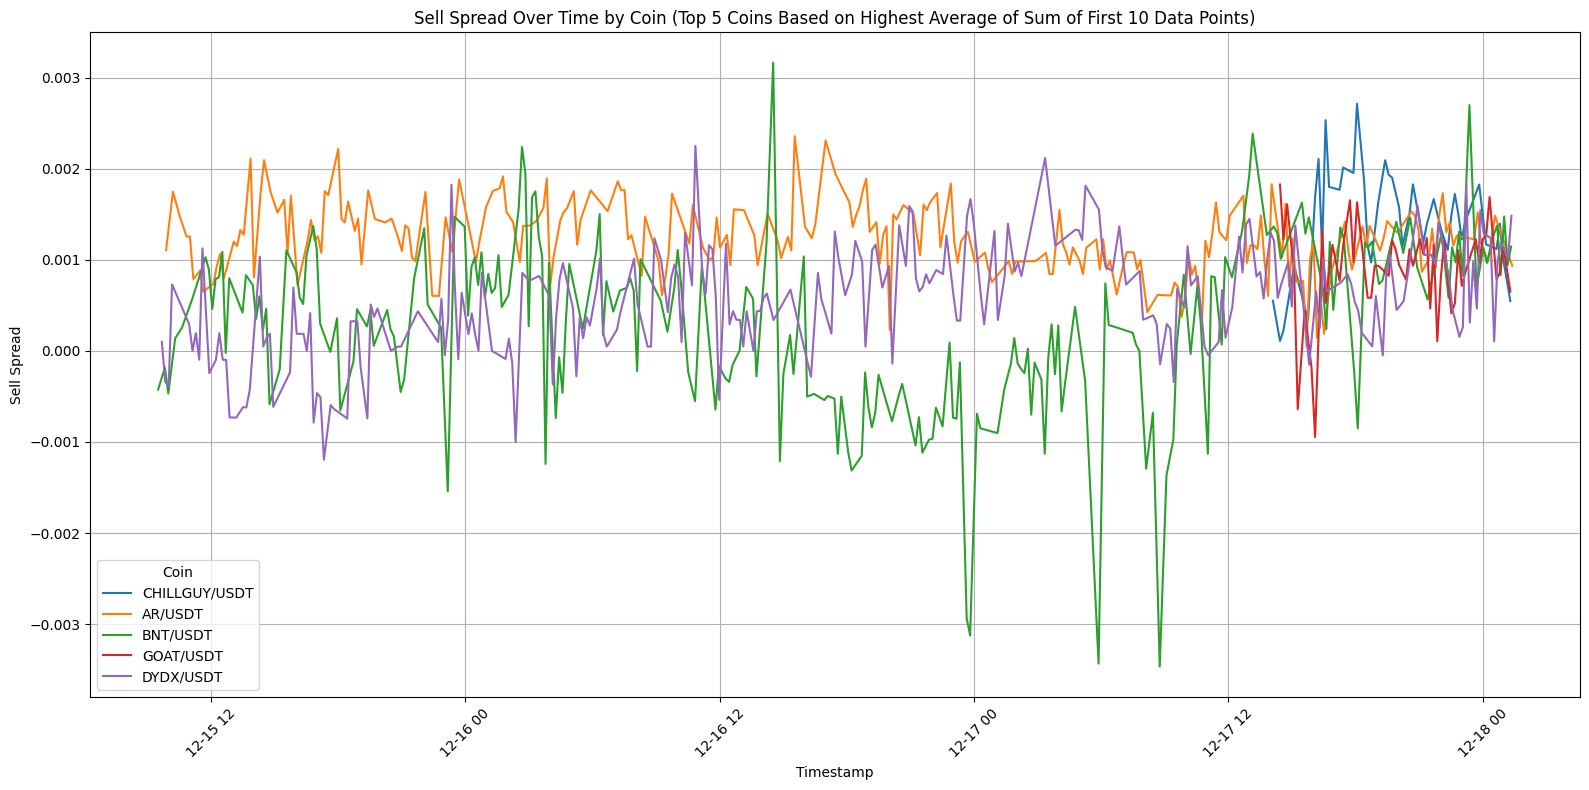

In [22]:
if len(top_five) > 0:
    plt.figure(figsize=(16, 8))
    # Plotting each of the top 5 coins
    for coin, score in top_five:
        subset = df[df['coin'] == coin]
        plt.plot(subset.index, subset['sell_spread'], label=coin)

    plt.title('Sell Spread Over Time by Coin (Top 5 Coins Based on Highest Average of Sum of First 10 Data Points)')
    plt.xlabel('Timestamp')
    plt.ylabel('Sell Spread')
    plt.legend(title='Coin')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No groups have enough data points.")

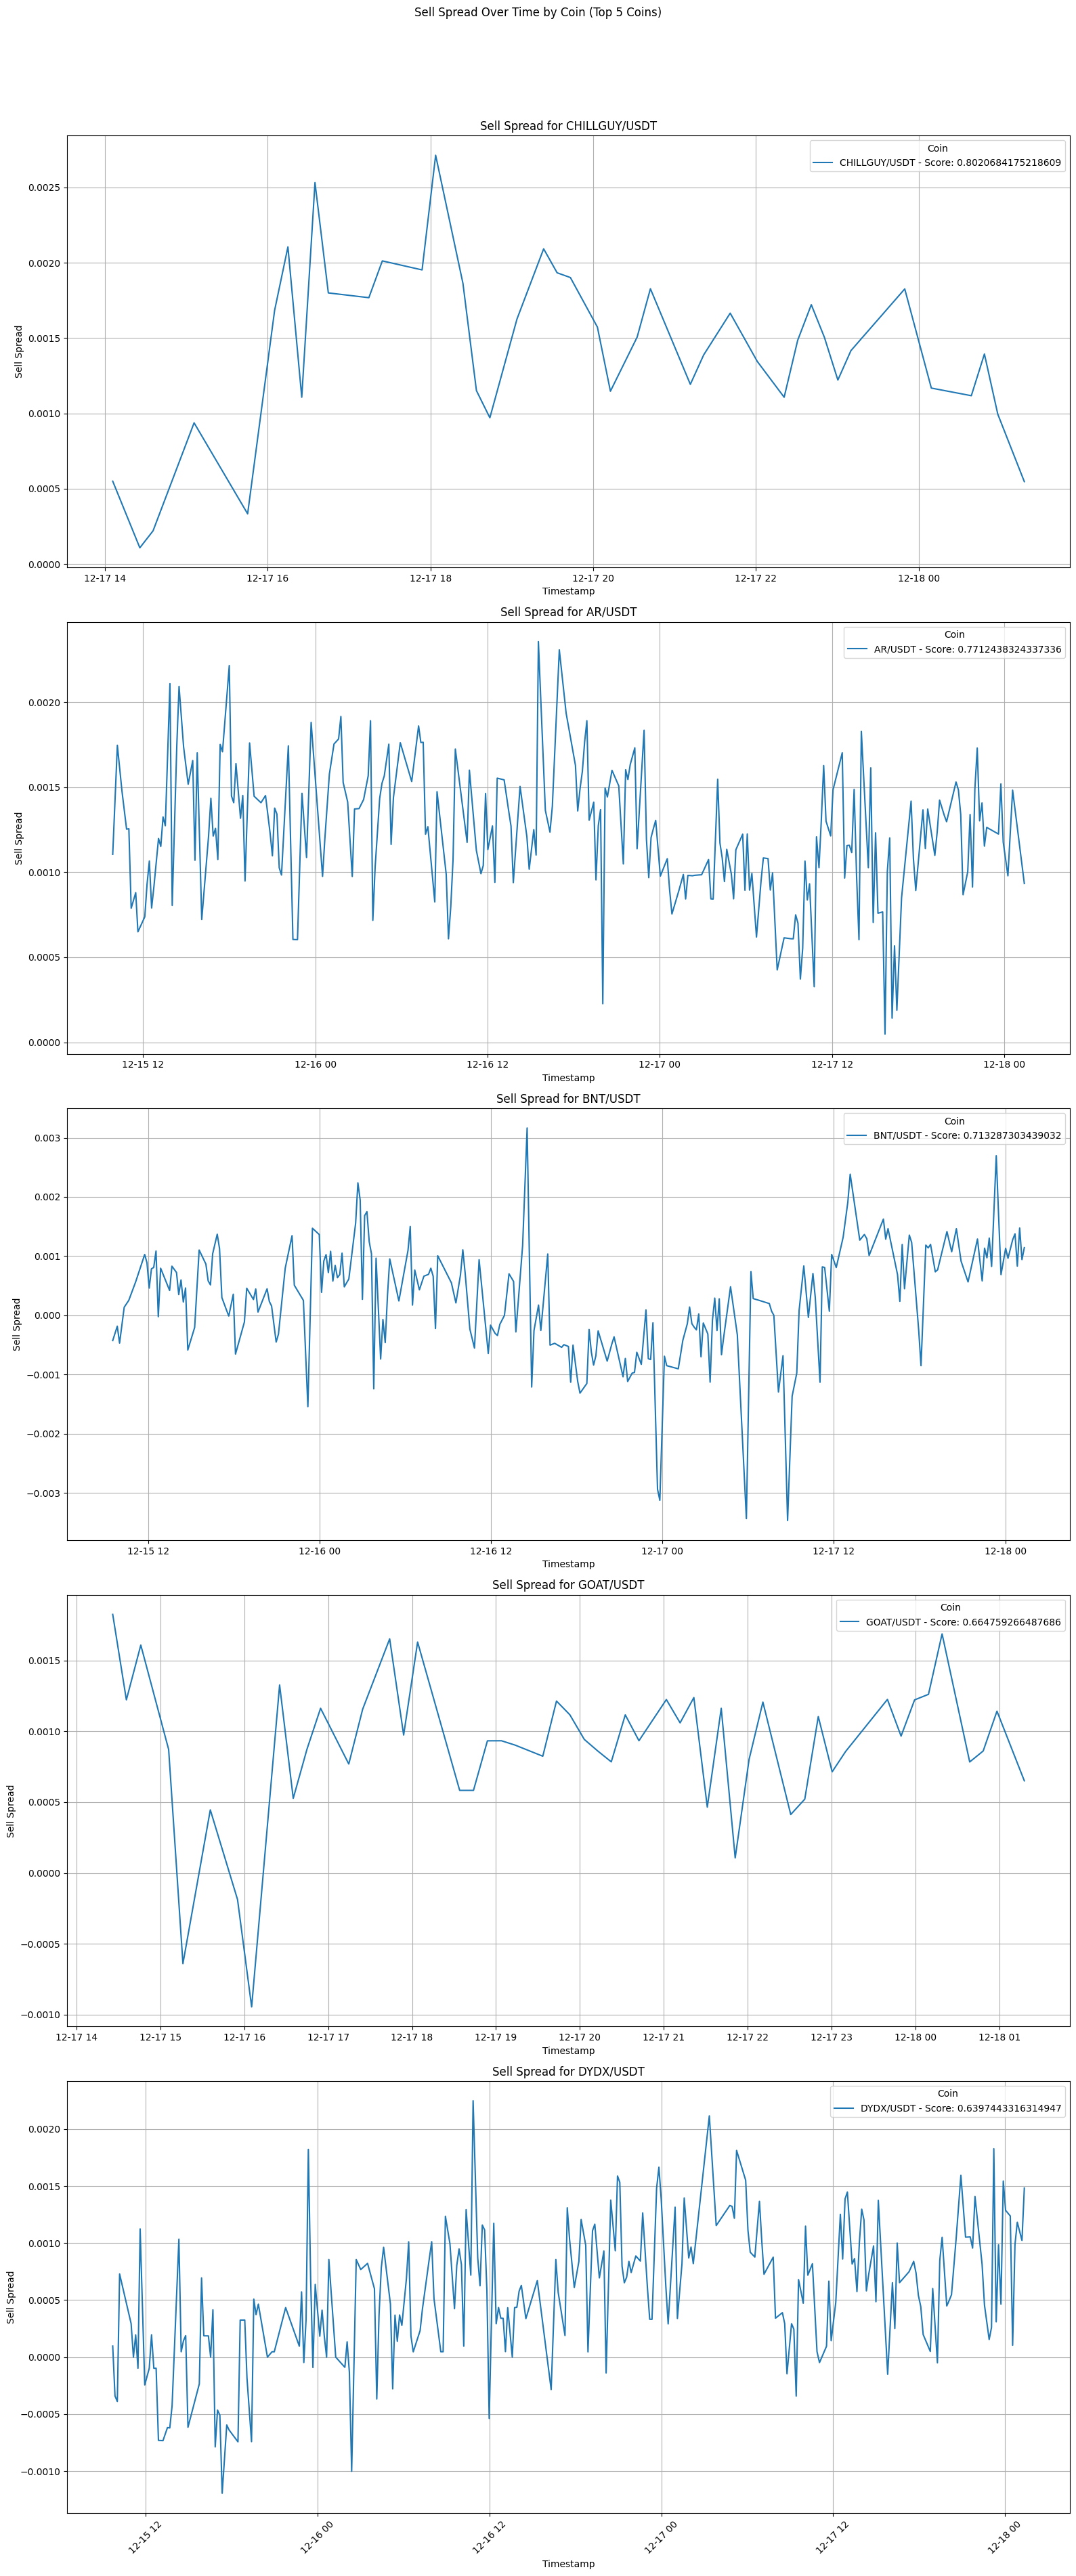

In [23]:
if len(top_five) > 0:
    # Create a figure with a subplot for each of the top 5 coins
    fig, axes = plt.subplots(len(top_five), 1, figsize=(16, 8 * len(top_five)))  # Adjusting subplot size
    fig.suptitle('Sell Spread Over Time by Coin (Top 5 Coins)')

    for (ax, (coin, score)) in zip(axes, top_five):
        subset = df[df['coin'] == coin]
        ax.plot(subset.index, subset['sell_spread'], label=f"{coin} - Score: {score}")
        ax.set_title(f'Sell Spread for {coin}')
        ax.set_xlabel('Timestamp')
        ax.set_ylabel('Sell Spread')
        ax.legend(title='Coin')
        ax.grid(True)

    plt.xticks(rotation=45)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to not overlap
    plt.show()
else:
    print("No groups have enough data points.")